<a href="https://colab.research.google.com/github/trey3p/emotion-music/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

Feature Extraction

In [2]:
def padding(array, xx, yy):
  #Takes numpy array, desired height, and width and pads the array.

  h = array.shape[0]
  w = array.shape[1]

  a = max((xx - h) // 2,0)
  aa = max(0,xx - a - h)

  b = max(0,(yy - w) // 2)
  bb = max(yy - b - w,0)

  return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

def extract_features(y):
  max_size = 1500 #Max audio file width

  #Getting short-time Fourier transform and padding
  stft = padding(np.abs(librosa.stft(y, n_fft = 225, hop_length = 512)), 128, max_size)

  #Getting MFCCs and padding
  mfccs = padding(librosa.feature.mfcc(y, n_fft = 225, hop_length = 512, 
                                       n_mfcc = 225, S = np.abs(stft)**2), 128, max_size)
  
  #Getting the spectral centroid

  spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
  
  #Getting chromagram
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  
  #Getting spectral bandwith
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)


  #Now padding the spectral pandwith and 
  image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
  image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 


  #Repeat padding for Spectral Bandwith, Spectral Centroid, Chromagram until they are the same
  # size as MFCC and STFT  
  for i in range(0,9):
    image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
    image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
    image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    
  image=np.dstack((image,np.abs(stft)))

  image=np.dstack((image,mfccs))

  return image


In [3]:
from google.colab import drive
drive.mount('/content/drive')

df_music = pd.read_csv("/content/drive/MyDrive/Colab '22 - Plante/music_labels.csv")

Mounted at /content/drive


In [4]:
import random
from tqdm import tqdm
output_files = os.listdir("/content/drive/MyDrive/Colab '22 - Plante/output")
output_files = random.sample(output_files, 500)
features = []
ad_names = []
ominous = []
uplifting = []
sad = []
other = []

for i in tqdm(range(len(df_music))):
  if df_music['alt'][i] in output_files:
    y, sr = librosa.load("/content/drive/MyDrive/Colab '22 - Plante/output/" + df_music['alt'][i] + "/accompaniment.wav", 
                         duration = 30)
    features.append(extract_features(y))
    ad_names.append(df_music['alt'][i])
    ominous.append(df_music['MUSIC1'][i])
    uplifting.append(df_music['MUSIC2'][i])
    sad.append(df_music['MUSIC3'][i])
    other.append(df_music['MUSIC90'][i])

np.concatenate(features, axis = 0)
dataset = pd.DataFrame({'Ad Name' : ad_names , 'Ominous-Tense': ominous, 'Uplifting' : uplifting, 
                        'Sad-Sorrowful' : sad, 'Other' : other, 
                        'Features' : features})


100%|██████████| 7357/7357 [21:57<00:00,  5.58it/s]


In [5]:
dataset.head()

,Ad Name,Ominous-Tense,Uplifting,Sad-Sorrowful,Other,Features
0,GOV_IN_HOLCOMB_ELISE,0,1,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,GOV_IN_HOLCOMB_HOOSIER_VALUES,0,1,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,GOV_KY_ADKINS_BLUEGRASS,0,1,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,GOV_KY_ADKINS_IT_IS_TIME,0,1,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,GOV_KY_BESHEAR_FUTURE_15,0,1,0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


Train & Test Sets

In [6]:
from sklearn.model_selection import train_test_split
X = np.array(features)
y = dataset[['Ominous-Tense', 'Uplifting', 'Sad-Sorrowful', 'Other']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 0, shuffle = True)

In [7]:
nsamples, nx, ny, nz = X_train.shape
d2_train_dataset = X_train.resize((nsamples,nx*ny*nz))

In [8]:
nsamples, nx, ny, nz = X_test.shape
d2_train_dataset = X_test.resize((nsamples,nx*ny*nz))

Model

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from tqdm import tqdm

cms = []
clf = OneVsRestClassifier(MLPClassifier(random_state = 0))
labels = ['Ominous-Tense', 'Uplifting', 'Sad-Sorrowful', 'Other']



for label in tqdm(labels):
  clf.fit(X_train, y_train[label])
  prediction = clf.predict(X_test)
  cms.append(confusion_matrix(y_test[label], prediction))
  print('Test accuracy for ' + label + ' is {}'.format(accuracy_score(y_test[label], prediction)))

 25%|██▌       | 1/4 [07:13<21:39, 433.17s/it]

Test accuracy for Ominous-Tense is 0.66


 50%|█████     | 2/4 [16:05<16:22, 491.42s/it]

Test accuracy for Uplifting is 0.62


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 75%|███████▌  | 3/4 [36:12<13:38, 818.22s/it]

Test accuracy for Sad-Sorrowful is 0.9


100%|██████████| 4/4 [40:57<00:00, 614.45s/it]

Test accuracy for Other is 0.9933333333333333


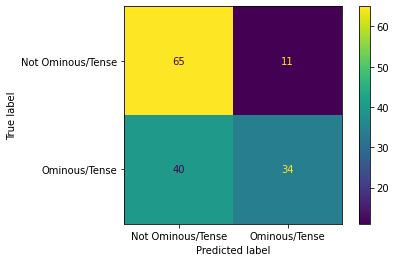

In [14]:
ConfusionMatrixDisplay(cms[0], display_labels = ['Not Ominous/Tense', 'Ominous/Tense']).plot()

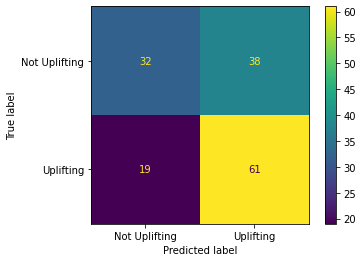

In [15]:
ConfusionMatrixDisplay(cms[1], display_labels = ['Not Uplifting', 'Uplifting']).plot()

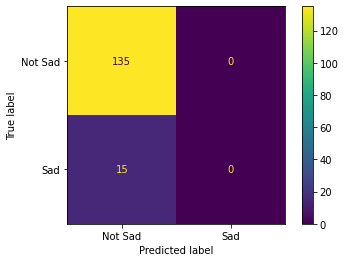

In [16]:
ConfusionMatrixDisplay(cms[2], display_labels = ['Not Sad', 'Sad']).plot()

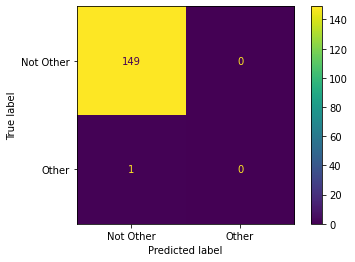

In [17]:
ConfusionMatrixDisplay(cms[3], display_labels = ['Not Other', 'Other']).plot()